In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data_dir = '../SkimLit_Project/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [3]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['../SkimLit_Project/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '../SkimLit_Project/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '../SkimLit_Project/pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [4]:
def get_lines(filename):
    with open(filename, 'r') as f:
        return f.readlines()

In [5]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
for line in train_lines[:10]:
    print(line.split('\t'))

['###24293578\n']
['OBJECTIVE', 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n']
['METHODS', 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n']
['METHODS', 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n']
['METHODS', 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .\n']
['METHODS', 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n']
['METHODS', 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TN

In [7]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines= ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split)-1
                
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
            
    return abstract_samples     

In [8]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

CPU times: total: 672 ms
Wall time: 698 ms


In [9]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [10]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


<AxesSubplot:ylabel='Frequency'>

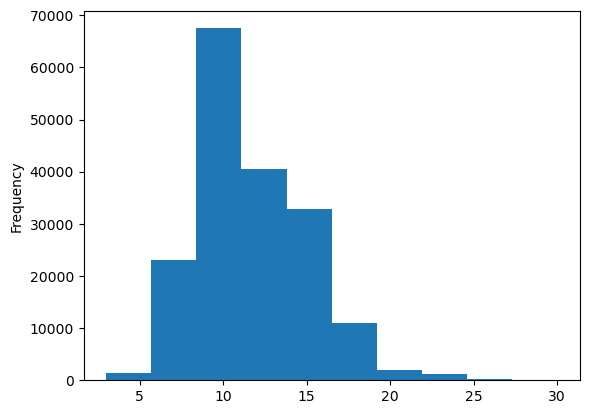

In [11]:
train_df.total_lines.plot.hist()

In [12]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [13]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [14]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

In [15]:
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [18]:
#----Models----
#1 - Naive Bayes with TF-IDF encoder
#2 - Conv1D with token embeddings
#3 - TensorFlow Hub Pretrained Feature Extractor
#4 - Conv1D with character embeddings
#5 - Pretrained token embeddings (same as 2) + character embeddings (same as 3)
#6 - Pretrained token embeddings + character embeddings + positional embeddings

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(
    train_sentences,
    train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [21]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred)*100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1-score": model_f1}
    return model_results

In [23]:
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1-score': 0.6989250353450294}

In [24]:
#Model-1
#Finding average length of sentences in the training data

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.round(np.mean(sent_lens))
avg_sent_len

26.0

(array([7.3163e+04, 8.1733e+04, 1.8772e+04, 4.5680e+03, 1.2400e+03,
        3.5400e+02, 1.1600e+02, 4.5000e+01, 1.7000e+01, 1.2000e+01,
        1.2000e+01, 3.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.        ,  20.66666667,  40.33333333,  60.        ,
         79.66666667,  99.33333333, 119.        , 138.66666667,
        158.33333333, 178.        , 197.66666667, 217.33333333,
        237.        , 256.66666667, 276.33333333, 296.        ]),
 <BarContainer object of 15 artists>)

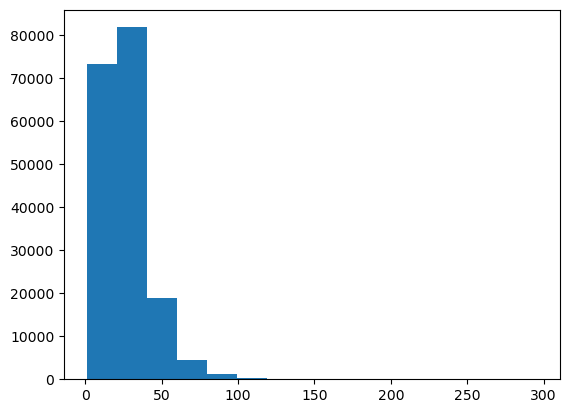

In [25]:
plt.hist(sent_lens, bins=15)

In [26]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [27]:
max_tokens = 68000

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = output_seq_len,
    pad_to_max_tokens=True
)

In [28]:
text_vectorizer.adapt(train_sentences)

In [29]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 `` the coach program '' was developed in australia as target driven educational telephone delivered intervention to support people with different chronic conditions .

Length of text: 166

Vectorized text: [[   2 7106  256   10  481    5 1696   25  492 4386  904 1032  785   38
     6  279  519    7  197  244  458    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [30]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [31]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True}

In [32]:
token_embed = tf.keras.layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    mask_zero = True,
    name='token_embedding'
)

In [33]:
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
print(f"Vectorized sentence shape: {vectorized_sentence.shape}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 `` the coach program '' was developed in australia as target driven educational telephone delivered intervention to support people with different chronic conditions .

Sentence after vectorization (before embedding):
 [[   2 7106  256   10  481    5 1696   25  492 4386  904 1032  785   38
     6  279  519    7  197  244  458    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Vectorized sentence shape: (1, 55)

Sentence after embedding:
 [[[ 0.00273906 -0.03621719 -0.02919917 ... -0.03867118 -0.0027074
   -0.04348738]
  [-0.00578468 -0.00376404  0.03207007 ...  0.01953218  0.03462989
   -0.00949457]
  [ 0.03772724 -0.04546225  0.04502401 ...  0.00348092  0.00975914
    0.03382533]
  ...
  [-0.0343977  -0.01226209  0.01615605 ... -0.03026294  0.01575447
    0.01626864]
  [-0.0343977  -0.01226209  0.01615605 ... -0.03026294  0.015754

In [34]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset, val_dataset, test_dataset

(<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>,
 <TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>,
 <TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>)

In [35]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [36]:
#Model-1
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_Conv1D_Token')

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
model_1.summary()

Model: "model_1_Conv1D_Token"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 51, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
____________________________________

In [38]:
model_1_history = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1 *len(val_dataset))
)

Epoch 1/5
562/562 [==============================] - 15s 21ms/step - loss: 0.9431 - accuracy: 0.6264 - val_loss: 0.7237 - val_accuracy: 0.7234
Epoch 2/5
562/562 [==============================] - 11s 20ms/step - loss: 0.6868 - accuracy: 0.7456 - val_loss: 0.6623 - val_accuracy: 0.7603
Epoch 3/5
562/562 [==============================] - 11s 20ms/step - loss: 0.6389 - accuracy: 0.7658 - val_loss: 0.6166 - val_accuracy: 0.7716
Epoch 4/5
562/562 [==============================] - 11s 20ms/step - loss: 0.6078 - accuracy: 0.7794 - val_loss: 0.5948 - val_accuracy: 0.7839
Epoch 5/5
562/562 [==============================] - 11s 20ms/step - loss: 0.6026 - accuracy: 0.7879 - val_loss: 0.5732 - val_accuracy: 0.7932


In [39]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5717 - accuracy: 0.7980


[0.5717340111732483, 0.7979610562324524]

In [40]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[5.2922732e-01, 1.7782696e-01, 5.3315051e-02, 1.8499327e-01,
        5.4637458e-02],
       [4.8181516e-01, 2.5811255e-01, 2.8693138e-02, 1.9117597e-01,
        4.0203225e-02],
       [1.9519117e-01, 6.8503004e-03, 2.0161176e-03, 7.9589337e-01,
        4.8952639e-05],
       ...,
       [2.5659832e-05, 6.3063850e-04, 2.9625401e-03, 2.8507211e-05,
        9.9635267e-01],
       [8.4832378e-02, 2.5359359e-01, 2.2257721e-01, 7.9612084e-02,
        3.5938475e-01],
       [1.7333665e-01, 6.5409374e-01, 1.4291541e-01, 1.3787505e-02,
        1.5866725e-02]], dtype=float32)

In [41]:
model_1_preds =tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [42]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 79.79610750695088,
 'precision': 0.7961424985247666,
 'recall': 0.7979610750695088,
 'f1-score': 0.7945987966997599}

In [43]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1-score': 0.6989250353450294}

In [45]:
import tensorflow_hub as hub

uni_sentence_encoder = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                     name='uni_sentence_encoder')

UnknownError: Failed to WriteFile: C:\Users\Gurpr\AppData\Local\Temp\tfhub_modules\063d866c06683311b44b4992fd46003be952409c.87dc21ef12df4d4997e0f0a03b89577a.tmp\variables\variables.data-00000-of-00001 : There is not enough space on the disk.
; operation in progress

In [ ]:
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = uni_sentence_encoder([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = uni_sentence_encoder(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE')

In [ ]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_2.summary()

In [ ]:
model_2_history = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    validation_data = val_dataset,
    epochs=5,
    validation_steps=int(0.1 * len(val_dataset))
)

In [ ]:
model_2.evaluate(val_dataset)

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

In [ ]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

In [ ]:
#Model-3

train_sentences[:5]

In [ ]:
def split_chars(text):
    return " ".join(list(text))

In [ ]:
split_chars(random_train_sentence)

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

print(train_chars[:5])

In [ ]:
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len

In [ ]:
plt.hist(chars_lens, bins=15)

In [ ]:
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

In [ ]:
NUM_CHAR_TOKENS = len(alphabet)
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    name='char_vectorizer'
)

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"Vectorized chars shape: {vectorized_chars.shape}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

In [ ]:
char_embed = layers.Embedding(
    input_dim = len(char_vocab),
    output_dim=25,
    mask_zero=True,
    name='char_embed'
)

In [ ]:
print(f"Charified text: {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars:\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

In [ ]:
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64,5,activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_Conv1D_Char')

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_3.summary()

In [ ]:
model_3_history = model_3.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_char_dataset)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1*len(val_char_dataset))
)

In [ ]:
model_3.evaluate(val_char_dataset)

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

In [ ]:
#Model-4

#Create a token-level embedding model
#Create a character level model
#Combine both models with a concatenate
#Build a series of output layers on top of the combo
#Construct a model which takes token and character level

In [ ]:
#Token model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = uni_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

#Char model
char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

#Concatenate
token_char_concat = tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name='model_4_token_and_char_embeddings')

In [ ]:
model_4.summary()

In [ ]:
model_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

In [ ]:
model_4_history = model_4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1*len(train_char_token_dataset)),
    epochs=5,
    validation_data = val_char_token_dataset,
    validation_steps=int(0.1*len(val_char_token_dataset))
)

In [ ]:
model_4.evaluate(val_char_token_dataset)

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [ ]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

In [ ]:
baseline_results, model_1_results, model_2_results, model_3_results

In [ ]:
#Model-5

train_df.head()

In [ ]:
train_df['line_number'].value_counts()

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot[:10]

In [ ]:
train_df['total_lines'].value_counts()

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 98)

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

In [ ]:
#Create a token-level model
#Create a character-level model
#Create a model for the line number feature
#Create a model for the total lines feature
#Combine the outputs of the first two models using concatenate
#Combine the features and the combined models using concatenate

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = uni_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

total_lines_inputs = layers.Input(shape=(20), dtype=tf.float32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output, char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output, total_line_model.output, z])

output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

model_5 = tf.keras.Model([line_number_model.input,
                         total_line_model.input,
                         token_model.input,
                         char_model.input], outputs=output_layer)

In [ ]:
model_5.summary()

In [ ]:
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
#Create training and validation datasets using all four sets of data

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                               train_total_lines_one_hot,
                                                               train_sentences,
                                                               train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                               val_total_lines_one_hot,
                                                               val_sentences,
                                                               val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_pos_dataset, val_char_token_pos_dataset

In [ ]:
model_5_history = model_5.fit(
    train_char_token_pos_dataset,
    epochs=5,
    steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
    validation_data=val_char_token_pos_dataset,
    validation_steps = int(0.1*len(val_char_token_pos_dataset)))

In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

In [ ]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results